In [1]:
""" Import libraries """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
import torch.utils.data as Data
from numpy import random
import imageio
from sklearn.preprocessing import MinMaxScaler
from utils import *
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from models.quantile_networks.diabetes_quantile_model import *
from models.mixture_density_networks.diabetes_mdn_model import MDN

random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
os.environ['PYTHONHASHSEED'] = str(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
""" Preprocess dataset """

from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X,Y = diabetes.data, diabetes.target

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))
# Scale both the training inputs and outputs
X_train = scaler_X.fit_transform(X_train)
y_train = scaler_Y.fit_transform(Y_train.reshape(-1,1))
x, y = Variable(torch.Tensor(X_train)), Variable(torch.Tensor(y_train))
torch_dataset = Data.TensorDataset(x, y)

X_test = scaler_X.transform(X_test)
y_test = scaler_Y.transform(Y_test.reshape(-1,1))
x_test, y_test = Variable(torch.Tensor(X_test)), Variable(torch.Tensor(y_test))

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=64, 
    shuffle=False, num_workers=2, worker_init_fn = lambda id: np.random.seed(id))

In [3]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

# Quantile Regression

Test R2 score: 0.363718518678786


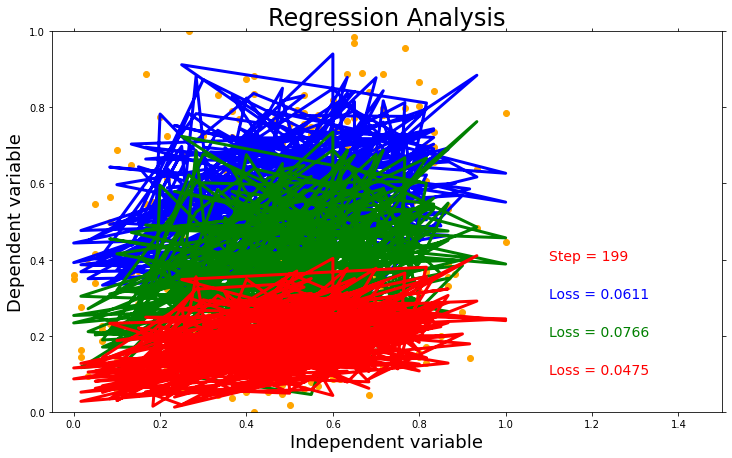

In [4]:
""" Train the network """
my_images = []
fig, ax = plt.subplots(figsize=(12,7))

net_common = Net_common(n_feature=10)     # define the network
net_upper = FC(n_feature=32)
net_middle = FC(n_feature=32)
net_lower = FC(n_feature=32)

optimizer_upper = torch.optim.SGD(list(net_common.parameters())+list(net_upper.parameters()), lr=3e-2, weight_decay=1e-5, momentum=1e-3)

optimizer_middle = torch.optim.SGD(list(net_common.parameters())+list(net_middle.parameters()), lr=3e-2, weight_decay=1e-5, momentum=1e-3)

optimizer_lower = torch.optim.SGD(list(net_common.parameters())+list(net_lower.parameters()), lr=3e-2, weight_decay=1e-5, momentum=1e-3)

loss_middle = 'inf'
loss_upper = 'inf'
loss_lower = 'inf'
for t in range(200):
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step  
        b_x = Variable(batch_x)
        b_y = Variable(batch_y) 
        if t%3==0:
            prediction_lower = net_lower(net_common(b_x))     # input x and predict based on x
            loss_lower = tilted_loss(0.2, b_y, prediction_lower)
            optimizer_lower.zero_grad()   # clear gradients for next train
            loss_lower.backward()         # backpropagation, compute gradients
            optimizer_lower.step()        # apply gradients
        elif t%3==1:
            prediction_middle = net_middle(net_common(b_x))     # input x and predict based on x
            loss_middle = tilted_loss(0.5, b_y, prediction_middle)
            optimizer_middle.zero_grad()   # clear gradients for next train
            loss_middle.backward()         # backpropagation, compute gradients
            optimizer_middle.step()        # apply gradients
        else:
            prediction_upper = net_upper(net_common(b_x))     # input x and predict based on x
            loss_upper = tilted_loss(0.8, b_y, prediction_upper)
            optimizer_upper.zero_grad()   # clear gradients for next train
            loss_upper.backward()         # backpropagation, compute gradients
            optimizer_upper.step()        # apply gradients
    with torch.no_grad():
        prediction_lower = net_lower(net_common(x))
        prediction_middle = net_middle(net_common(x))
        prediction_upper = net_upper(net_common(x)) 
          # plot and show learning process
        prediction_middle_test = net_middle(net_common(x_test))
        plt.cla()
        ax.set_title(f'Regression Analysis', fontsize=24)
        ax.set_xlabel('Independent variable', fontsize=18)
        ax.set_ylabel('Dependent variable', fontsize=18)
        ax.set_xlim(-0.05, 1.5)
        ax.set_ylim(0, 1)
        ax.scatter(x.data.numpy()[:,0], y.data.numpy(), color = "orange")
        ax.plot(x.data.numpy()[:,0], prediction_upper.data.numpy(), 'b-', lw=3)
        ax.plot(x.data.numpy()[:,0], prediction_middle.data.numpy(), 'g-', lw=3)
        ax.plot(x.data.numpy()[:,0], prediction_lower.data.numpy(), 'r-', lw=3)
        ax.text(1.1, 0.4, 'Step = %d' % t, fontdict={'size': 14, 'color':  'red'})
        try:
            ax.text(1.1, 0.3, 'Loss = %.4f' % loss_upper.data.numpy(),
                fontdict={'size': 14, 'color':  'blue'})
        except:
            ax.text(1.1, 0.3, 'Loss = inf',
                fontdict={'size': 14, 'color':  'blue'})
        try:
            ax.text(1.1, 0.2, 'Loss = %.4f' % loss_middle.data.numpy(),
                fontdict={'size': 14, 'color':  'green'})
        except:
            ax.text(1.1, 0.2, 'Loss = inf',
                fontdict={'size': 14, 'color':  'green'})
        try:
            ax.text(1.1, 0.1, 'Loss = %.4f' % loss_lower.data.numpy(),
                fontdict={'size': 14, 'color':  'red'})
        except:
            ax.text(1.1, 0.1, 'Loss = inf',
                fontdict={'size': 14, 'color':  'red'})
        # Used to return the plot as an image array 
        # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        my_images.append(image)

# save images as a gif
imageio.mimsave(f'../plots/training_quantile_diabetes.gif', my_images, fps=10)

prediction_middle = net_middle(net_common(x_test))
print(f"Test R2 score: {r2_score(y_test.detach().numpy(), prediction_middle.detach().numpy())}")

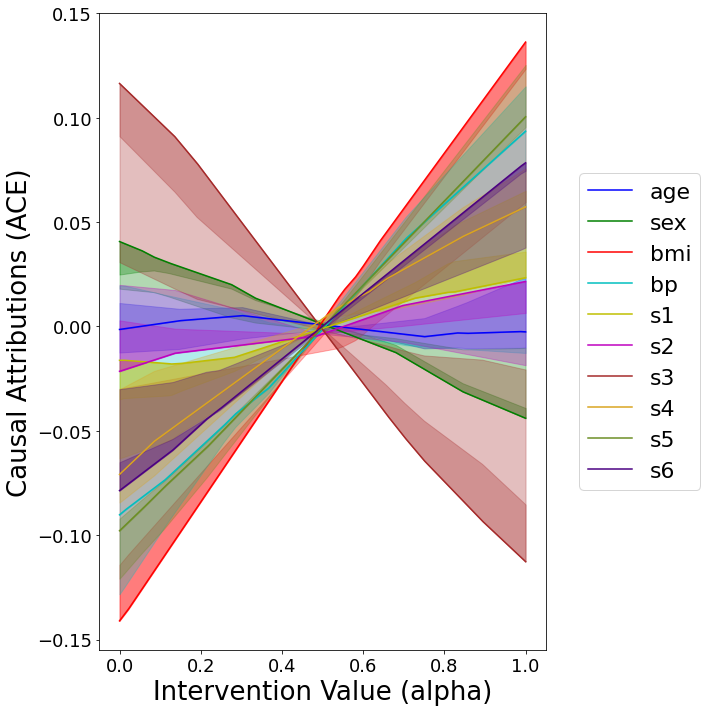

In [5]:
""" Causal Attribution for Quantile Networks"""
from SACE.SACE_quantile import plot_sace_quantile

plot_sace_quantile(x = x, 
                   net_common=net_common,
                   net_upper = net_upper,
                   net_middle = net_middle,
                   net_lower = net_lower,
                   num_c=10,
                   extend_plot=True,
                   feature_names=diabetes.feature_names,
                   filename = "../plots/quantile_diabetes_causal_attribution",
                   title = "Causal Attribution for Diabetes dataset")

Most important feature: [2 6]
Least important feature: [0 5]


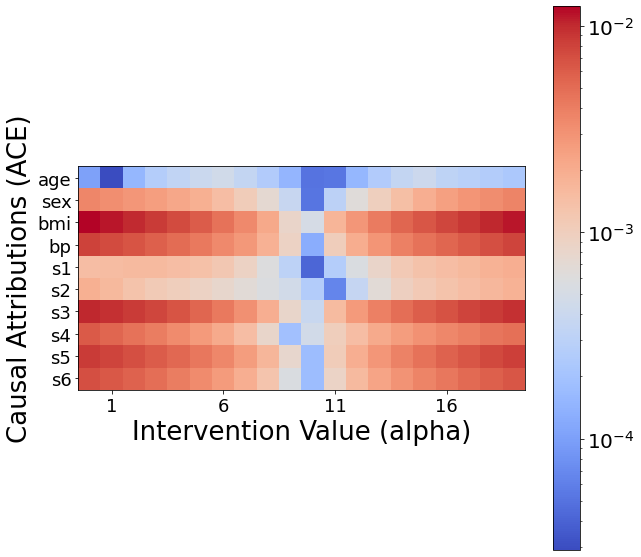

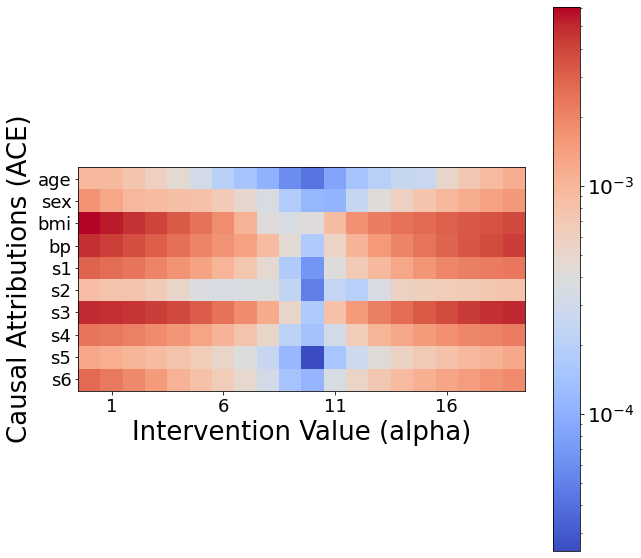

In [6]:
""" Causal Attribution for Quantile Networks - Saliency Map """
from SACE.SACE_quantile import plot_sace_quantile_saliency_map

plot_sace_quantile_saliency_map(x = x, 
                                net_common=net_common,
                                net_upper = net_upper,
                                net_middle = net_middle,
                                net_lower = net_lower,
                                num_c=10,
                                feature_names=diabetes.feature_names,
                                filename = "../plots/quantile_diabetes_causal_attribution_saliency_maps",
                                title = "Causal Attribution for Diabetes dataset")

# Mixture Density Network

Test R2 score: 0.366564411913442


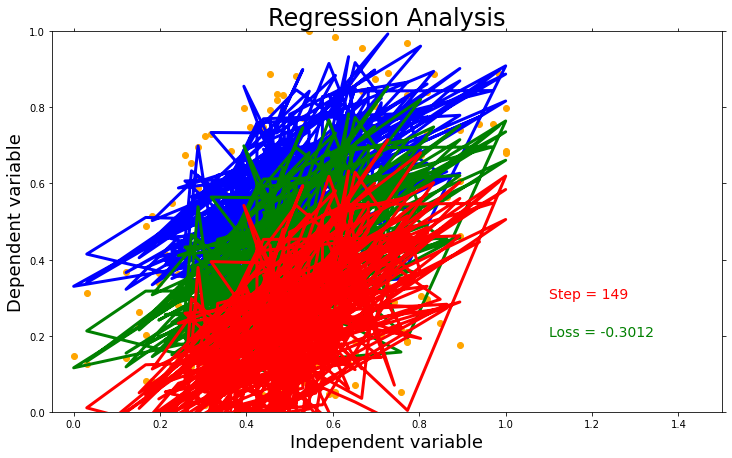

In [7]:
""" Train the network """
my_images = []
fig, ax = plt.subplots(figsize=(12,7))

net = MDN(n_feature=10, n_gaussians=1)     # define the network
# print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=3e-3, weight_decay=1e-5, momentum=1e-3)

for t in range(150):
  for step, (batch_x, batch_y) in enumerate(loader): # for each training step  
    b_x = Variable(batch_x)
    b_y = Variable(batch_y) 

    prediction_pi, prediction_mu, prediction_sigma = net(b_x)     # input x and predict based on x
    loss = mdn_loss_fn(b_y, prediction_mu, prediction_sigma, prediction_pi)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

  prediction_pi, prediction_mu, prediction_sigma = net(x)
  prediction_pi_test, prediction_mu_test, prediction_sigma_test = net(x_test)
      # plot and show learning process
  plt.cla()
  ax.set_title(f'Regression Analysis', fontsize=24)
  ax.set_xlabel('Independent variable', fontsize=18)
  ax.set_ylabel('Dependent variable', fontsize=18)
  ax.set_xlim(-0.05, 1.5)
  ax.set_ylim(0, 1)
  ax.scatter(x.data.numpy()[:,-1], y.data.numpy(), color = "orange")
  ax.plot(x.data.numpy()[:,-1], (prediction_mu+prediction_sigma).data.numpy(), 'b-', lw=3)
  ax.plot(x.data.numpy()[:,-1], prediction_mu.data.numpy(), 'g-', lw=3)
  ax.plot(x.data.numpy()[:,-1], (prediction_mu-prediction_sigma).data.numpy(), 'r-', lw=3)
  ax.text(1.1, 0.3, 'Step = %d' % t, fontdict={'size': 14, 'color':  'red'})
  
  ax.text(1.1, 0.2, 'Loss = %.4f' % loss.data.numpy(),
          fontdict={'size': 14, 'color':  'green'})
  # Used to return the plot as an image array 
  # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
  fig.canvas.draw()       # draw the canvas, cache the renderer
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
  image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

  my_images.append(image)

# save images as a gif
imageio.mimsave(f'../plots/training_mdn_diabetes.gif', my_images, fps=10)

prediction_pi, prediction_mu, prediction_sigma = net(x_test)
print(f"Test R2 score: {r2_score(y_test.detach().numpy(), prediction_mu.detach().numpy())}")

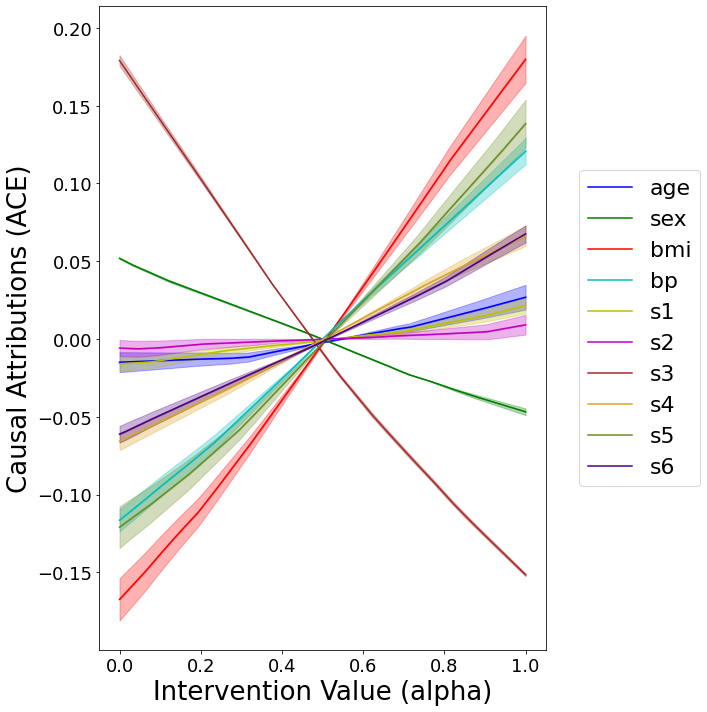

In [8]:
""" Causal Attribution for MDN networks"""
from SACE.SACE_mdn import plot_sace_mdn

plot_sace_mdn(x=x, 
              net=net,
              filename="../plots/mdn_diabetes_causal_attribution",
              num_c=10,
              extend_plot=True,
              feature_names=diabetes.feature_names,
              title="Causal Attribution for Diabetes dataset")

Most important feature: [2 6]
Least important feature: [5 4]


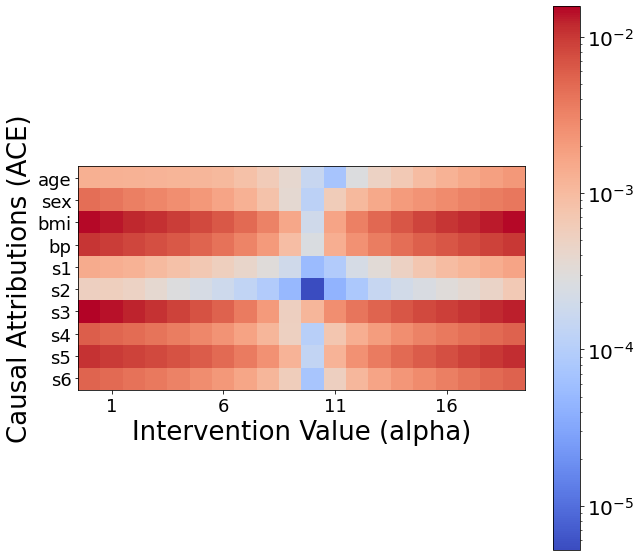

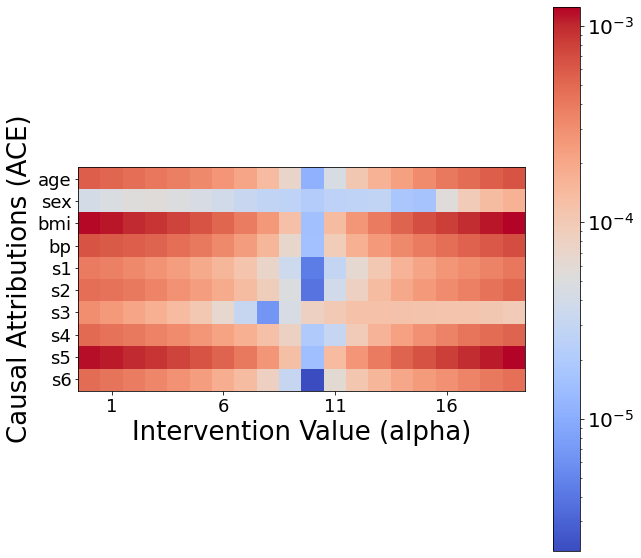

In [9]:
""" Causal Attribution for MDN Networks - Saliency Map """
from SACE.SACE_mdn import plot_sace_mdn_saliency_map

plot_sace_mdn_saliency_map(x = x, 
                           net=net,
                           num_c=10,
                           feature_names=diabetes.feature_names,
                           filename = "../plots/mdn_diabetes_causal_attribution_saliency_maps",
                           title = "Causal Attribution for Diabetes dataset")